# Содержание

1. [Исследовательский анализ данных](#eda)
2. [Модель прогнозирования оттока клиентов](#forecast_model)
3. [Кластеризация клиентов](#сlustering)
4. [Вывод](#fin)

<a id='eda'></a>
## Исследовательский анализ данных

**to do:**
***
1. Импоритровать необходимые библиотеки.
2. Выполнить загрузку данных.
3. Проверить данные на пропущенные значения и дубликаты. 
4. Проверить соответствие данных их типу.
5. Посмотреть на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
6. Построить столбчатые гистограммы и распределения признаков для тех, для клиентов в оттоке и действующих клиентов;
7. Построить матрицу корреляций.

**Загрузка данных**

In [ ]:
# Основные библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.cluster.hierarchy import dendrogram, linkage


# Библиотеки визуализации
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


# Библиотеки для прогнозирования
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans

# Дополнительные библиотеки
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import os

# Отклчючение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Отлично, данные успешно загружены.  
Перейдем к проведению исследовательского анализа.

**Проверка на пропуски, дубликаты и соответствие типу данных**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [ ]:
print('Количество дубликатов в датасете: {}'.format(df.duplicated().sum()))
print('Доля дубликатов: {:.0%}'.format(df.duplicated().mean()))

Количество дубликатов в датасете: 0
Доля дубликатов: 0%


1. Пропусков и дубликатов нет;
2. Категориальные признаки уже приведены в числовые значения.  
Остальные признаки имеют соответсвующий тип данных.
3. Названия полей в верхнем регистре, для удобства проведения исследования передеведем в нижний


In [ ]:
df.columns = df.columns.str.lower()
df.columns 

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Проверим какие значения лежат в категориальных признаках.


In [ ]:
list_feature = ['gender',
                   'near_location', 
                   'partner',
                   'promo_friends',
                   'phone','group_visits',
                ]

In [ ]:
for feature in list_feature:
    print(feature)
    print('Список значений признака:')
    print(df[feature].unique())
    print('---------------------------------')

gender
Список значений признака:
[1 0]
---------------------------------
near_location
Список значений признака:
[1 0]
---------------------------------
partner
Список значений признака:
[1 0]
---------------------------------
promo_friends
Список значений признака:
[1 0]
---------------------------------
phone
Список значений признака:
[0 1]
---------------------------------
group_visits
Список значений признака:
[1 0]
---------------------------------


Итого, в большинстве полей мы имеем бинарную величину.  
Поехали дальше!

**Оценка основных статистических данных**

In [ ]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Вывод:**
***
1. 84% клиентов живут в раойне фитнес центра
2. Чуть меньше половины, а именно 48% клиентов являются сотрудниками компаний-партнеров.
3. 1/3 всех клиентов использовала промокод для скидки. Это достаточно большое количесво. Люди не упускают возможность сэкономить, фитнес клуб не исключение.
4. 10% пользователей не указывали свой контактный номер телефона.
5. Больше половины клиентов не посещают групповых занятия.
6. Средний возраст составляет 30 лет со стандартным отклонением в 3 года.  
Самый младшие клиенты в возрасте 18 лет, самые старшие в 41 год.
7. Самые популярные абоненты на 1 месяц.
8. В клубе есть клиенты, которые занимаются более 2 лет, а есть которые занимаются первый месяц. Средний срок находения клинетов  - 3 месяца.

**Распределение признаков в группе с оттоком клиентов и в группе с действующими клиентами**

In [ ]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Дополнительно напишем функцию, которая будет нам отрисовывать гистограмму по каждой группе.  
На вход функция будет принимать один параметр - признак датасета.

In [ ]:
def histogram (feature):
    plt.figure(figsize=(12,5))
    plt.suptitle('Распределение признака: {}'.format(feature), fontsize=15)

    # График распределения отток клиентов
    plt.subplot(121)
    plt.hist(df.loc[df['churn'] == 0, feature], color='#053742')
    plt.title('Для действующих', fontsize=12)
    plt.xlabel('Значение признака', fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 12)
    plt.grid()

    # График распределения действующих клиентов
    plt.subplot(122)
    plt.hist(df.loc[df['churn'] == 1, feature], color='#4F0E0E')
    plt.title('Для оттока', fontsize=12)
    plt.xlabel('Значение признака', fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 12)
    plt.grid()

Для быстроты построения запустим цикл по каждому признаку датасета.

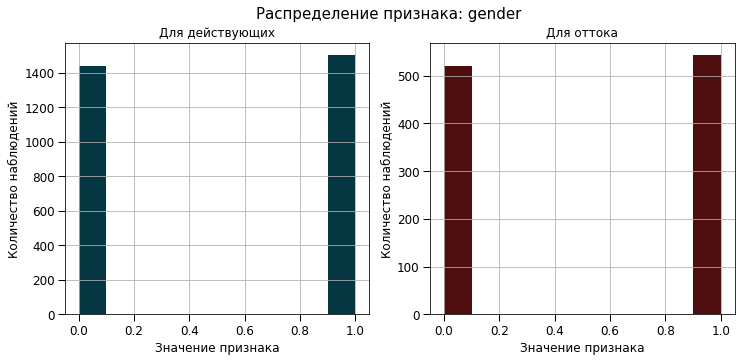

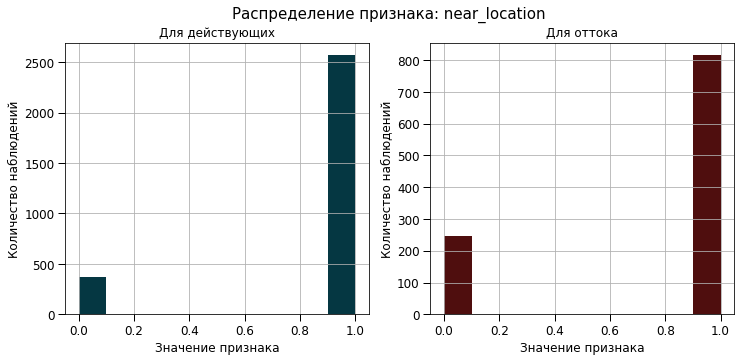

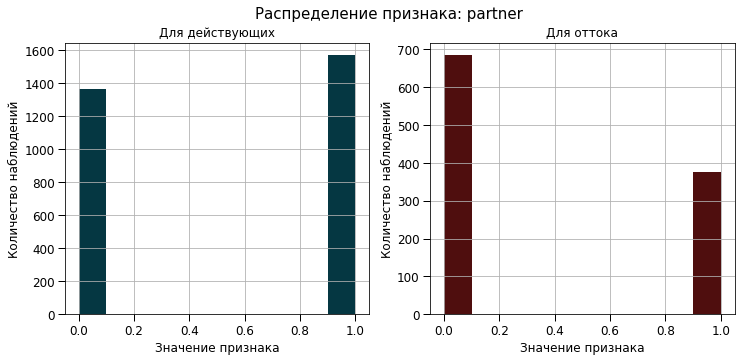

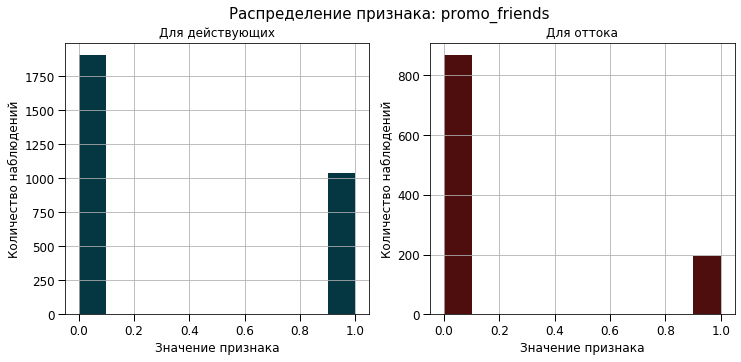

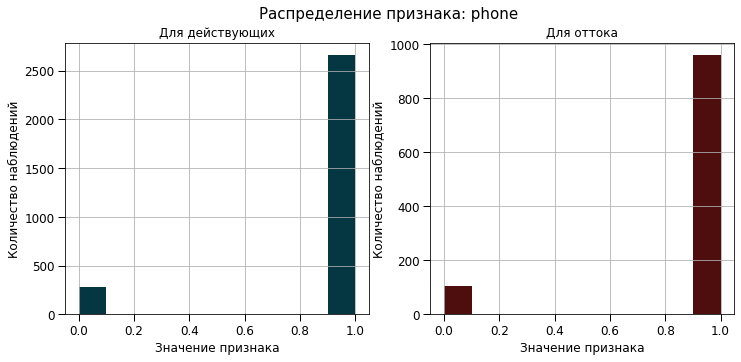

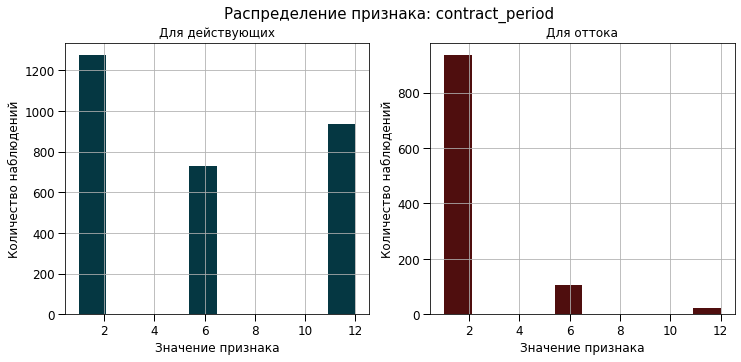

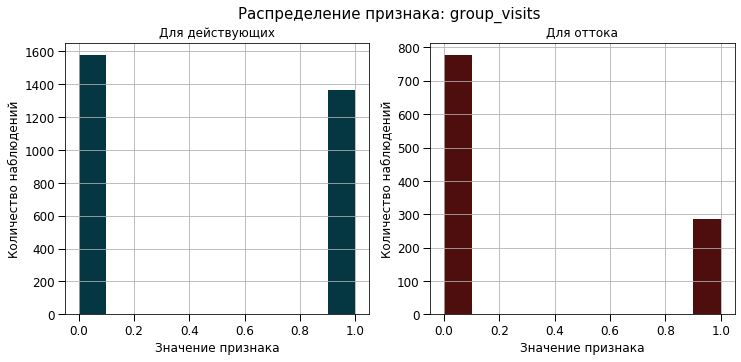

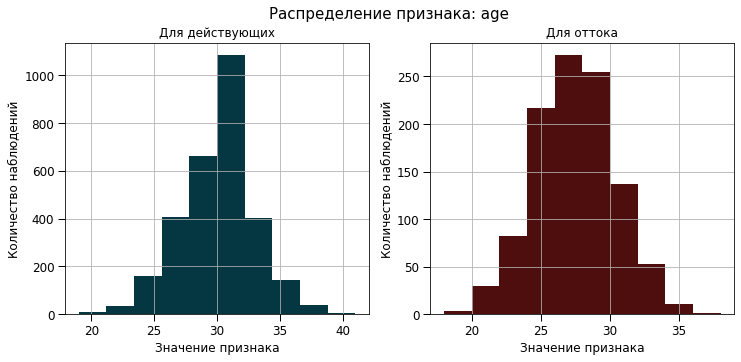

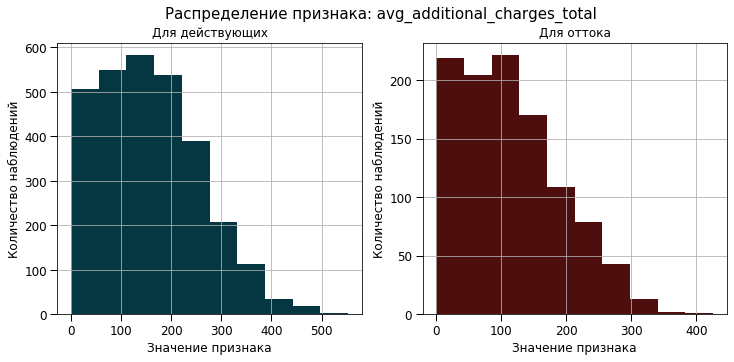

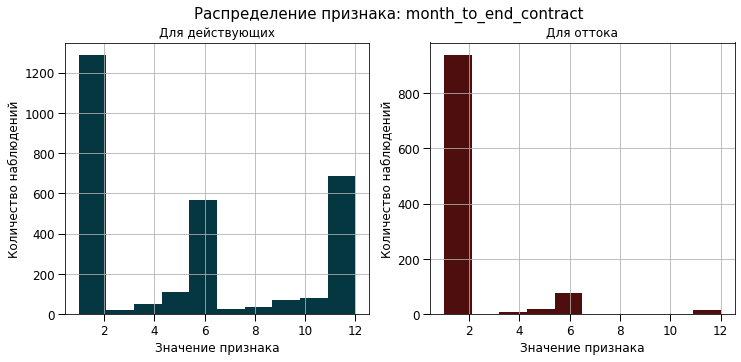

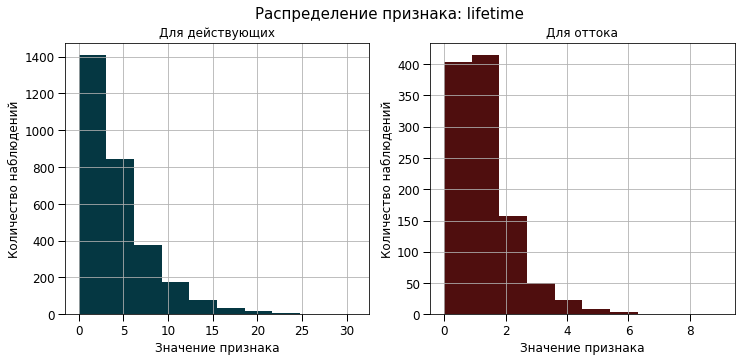

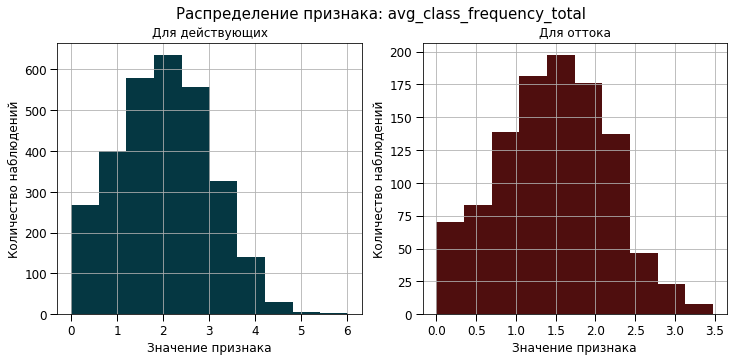

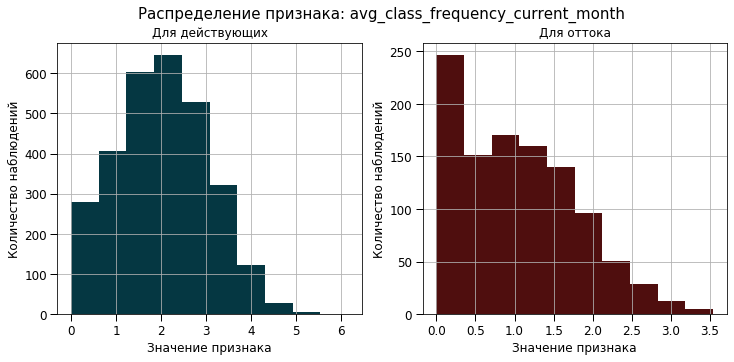

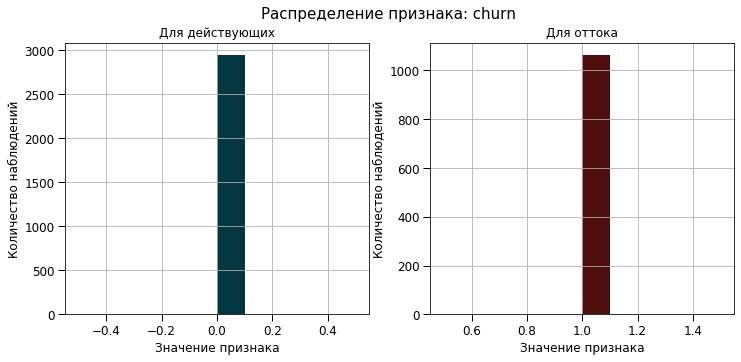

In [ ]:
for feature in df.columns:
    histogram(feature)

**Вывод**
***
1. По половому признаку соотношение количества клиентов в обоих группах одинаковое, как и возраст клиента от 25 до 30 лет.
2. В группе с действующими клиентами, доля тех которые живут в одном районе с фитнес клубом выше чем в гурппе с оттоком. Вероятней всего факт расположения влияет на решение заниматься именно в этом зале. 
3. Доля сотрудников компаний-партнеров также больше в группе с действующими клиентами, и составляет 53% против 35%. Этот факт лояльности также влияет на решение клиента покинуть или остаться. 
4. Аналогично проихсодит и с промокодом. В группе с оттоком количество таких клинетов не превышает 18%, остальные же 82% занимались без скидки.
5. Средний контрактный период в группе с оттоком составляет 1.7 месяцев, рспределение признака показывает низкую вариативность, у действующих клиентов 5.7 месяцев. Можно предположить, следующее:
    - клиентов все устраивает и они берут абонент на более длительный срок
    - Либо длительный срок является обязательным для сотрудников компаний-партнеров, как одно из условий скидки.
    - либо абоненты на длительный срок более дешевле в цене.
6. Групповые занятия посещают больше действующие клиенты.
7. Распределение суммарной выручки в боих группах смещено влево. В среднем, действующие клиенты платят больше за доп.услуги, чем клиенты в оттоке.
8. Дискретность посещений у действующих клинетов больше в 2 раза чем у клиентов в оттоке.
9. Срок жизни в группе с оттоком клинетов всего 1 месяц, в другой 4.7 месяца. Это очевидно: клиента все устраивает, клиент продолжает посещать
10. Очень низкая средняя посещаемость в неделю как за весь период жизни, так и за прошлый месяц в группе с оттоком, в 2 раза меньше чем в группе с действующими клиентами.
11. И наконец, тех кто ходит в клуб 3000, тех кто числится в оттоке 1000 человек.
   

**Оценка связей признаков**

Простроим матрицу корреляций для всех признаков датасета

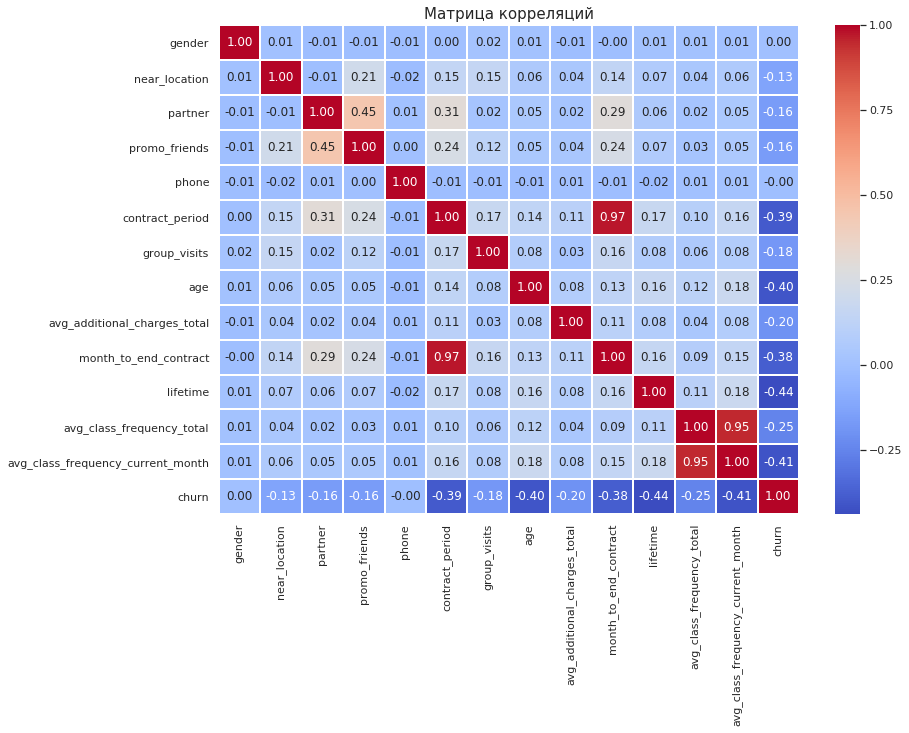

In [ ]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Матрица корреляций', fontsize=15)
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=1, cmap='coolwarm')
plt.show()

**Вывод**
*** 
**Предположительная оценка связи признаков с целевой переменной**

Из результатов анализа, мы видим,что целевая переменная имеет обратную связь со всеми признаками, за исключанием пола - там нет связи.  
Для собственного понимания можно сказать так:
- там где признак имеет значение 1, целевая переменная принимает значаение 0
- там где непрерывная величина больше, целевая переменная принимает значение 0

Итого:
1. Чем больше срок жизни, тем больше вероятность того, что клиент останется в клубе;
2. Чем больше клиенту лет, тем меньше его желание менять зал;
3. Чем чаще он посещал в прошлом месяце клуб, чем больше ожидания его визита;
4. Чем больше у него контрактный период, чем меньше ожидание того, что он уйдет.
5. И соответственно, чем больше времени до окончания периода, чем меньше ожидание того,что он уйдет.

***

**Выделим пары признаков, которые имеют наиболее сильную, прямую связь:**
1. Сотрудники компаний-партнеров с:
    - Акция "Приведи друга";
    - Контрактнй период
    - Конец контракктного периода
2. Размещение в одном раойне с клубом с:
    - Акция "Приведи друга";
    - Контрактнй период;
    - Групповые занятия;

Итого, можно "нарисовать" следующий портрет связи признаков данных:  
*Если клиент является сотрудником компании-партнера, то как правило он приводит друга/коллегу из этой же компании. Для таких клиентов предусмотрен фиксированный контрактный период и групповые занятия.*

***

**Связи, которые обладают мультиколлинеарностью:**
1. Контрактный период с концом контрактного периода;
2. Средняя частота посящений в неделю за предыдующий месяц и за весь период;

Эта сильная связь вполне объяснима:
- в первом случае срез производился в один день, а значит, те клинеты, которые пришли в один день и имеют одинаковый контрактный период, имеют идентичныый значения и по его окончанию.
- во втором случае для многих клиентов оттока предыдущий месяц мог первым и последним *(т.е. предыдущий месяц = весь период)*, т.к. их средний срок жизни 1 месяц, отсюда и сильная связь. Ну или в принципе дискретность посещений из месяц в месяц не отличается.



<a id='forecast_model'></a>
## Модель прогнозирования оттока клиентов

**to do:**
***
1. Раделить данные на обучающую и валидационную выборку;
2. Обучить модель на *train-выборке* двумя способами:
    - логистической регрессией,
    - случайным лесом.
3. Провести оценку метрик `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке. Сделать вывод о том, какая показала себя лучше на основании метрик.

Посмотрим на соотношение классов.  
Результат нам понадобиться при интепретации метрик качества моделей.

In [ ]:
print('Соотношение классов: ')
print(df['churn'].value_counts(normalize=True).round(2))

Соотношение классов: 
0    0.73
1    0.27
Name: churn, dtype: float64


Обучм модели по двум алгоритмам: "Логистическая регрессия" и "Случайный лес".  
Так как мы имеем мульколлинеарность некоторых признаков, проведем регуляризацию, передаадим в параметр `penatly` значение `l2`. Таким образом мы проведем регуляризацию методом `ridge` - равномерное распределение весов признака.

In [ ]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Агоритм для нашей модели: Логистическая регрессия и Случайный лес
lgr_model = LogisticRegression(penalty='l2', random_state=0)
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# Обучение моделей
lgr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Прогнозирование по каждой модели
lgr_predictions = lgr_model.predict(X_test) 
rf_predictions = rf_model.predict(X_test)


In [ ]:
print('Метрики качества модели: ' + '\033[1m' + 'Логистическая регрессия' + '\033[0m')
print('-----------------------------------')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,lgr_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test,lgr_predictions)))
print('Recall: {:.2f}'.format(recall_score  (y_test,lgr_predictions)))

Метрики качества модели: Логистическая регрессия
-----------------------------------
Accuracy: 0.93
Precision: 0.86
Recall: 0.83


In [ ]:
print('Метрики качества модели: ' + '\033[1m' + 'Случайный лес' + '\033[0m')
print('----------------------------------------------------')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,rf_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test,rf_predictions)))
print('Recall: {:.2f}'.format(recall_score  (y_test,rf_predictions)))

Метрики качества модели: Случайный лес
----------------------------------------------------
Accuracy: 0.92
Precision: 0.84
Recall: 0.82


**Вывод**
***
1. **Доля правильных ответов** у модели, обученной алгоритмом "Случайный лес" не много выше, чем у модели с алгоритмом "Логистическая регрессия". Напомним, что для этой метрики важен баланс классов 50 на 50, в нашем же исселодовании 70 на 30. Делать выводы по этой метрики мы не можем.
2. **Точность** - показывает какая доля прогнозов относительно 1 класса верна.  *Другими словами, мы определяем долю где мы прогнозируем 1 класс среди реальных значений 1 и 0 класса.*  
Здесь у нас лидирует модель, постороенная алгоритмом  "Случайный лес". В отношении ее, с точностью до 84%, мы можем утверждать о том, что выборка относится к 1 классу.
3. **Полнота** - показывает сколько реальных объектов 1 класса вы смогли обнаружить с помощью модели.В отличии от **точности**, эта метрика не зависит от того, как предсказываются негативные семплы.  *Другими словами, мы определяем долю где мы прогнозируем 1 класс среди реальных значений 1 класса.*  
Незначительно, но все же модель построенная алгоритмом "Случайный лес" превосходит модель, построенную "Логистической регрессией".


<a id='сlustering'></a>
## Кластеризация клиентов

**to do:**
***
1. Стандартизировать данные;
2. Выделить число классов на основе дендограммы;
3. Использовать полученное число классов в методе кластеризации "K-Means";
4. Определить средние значения признаков для каждого кластера;
5. Построить гистограммы признаков по каждому кластеру;
6. Посчитать долю оттока в каждом кластере.


Проведем стандартизацию данных

In [ ]:
# обязательная стандартизация данных перед работой с алгоритмами
scaler = StandardScaler()
x_sc = scaler.fit_transform(df.drop(columns = ['churn']))

# Создание таблицы связок между объектами
linked = linkage(x_sc, method = 'ward')

Построим дендограмму

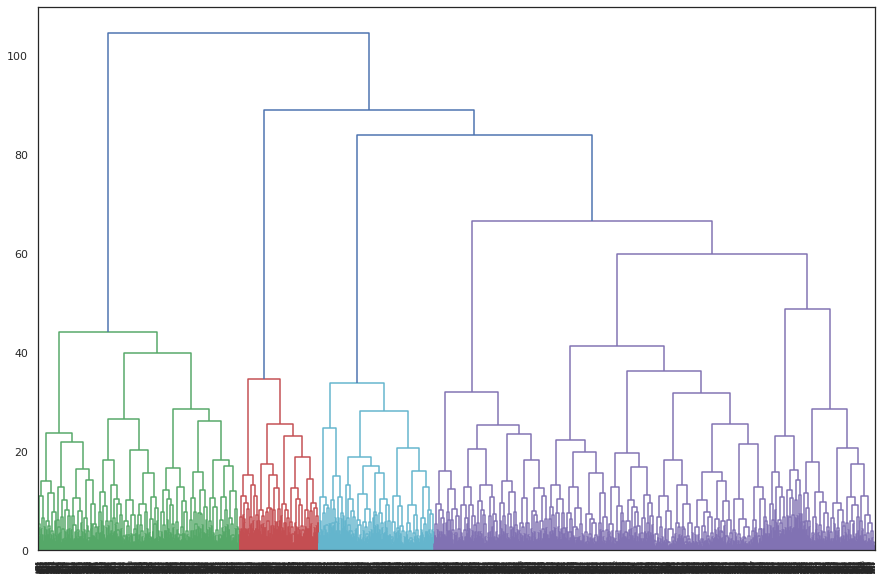

In [ ]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

По всем представленным цветам графика **выделяем 4 класса**, которые мы будем использоваться при обучении модели методом кластеризации, на основании алгоритма K-Means.

**Обучим модель кластеризации на основании алгоритма K-Means**

In [ ]:
# задаём число кластеров, равное 4
km = KMeans(n_clusters = 4)

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(x_sc)

In [ ]:
df['cluster_km'] = labels

In [ ]:
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').mean().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.54,0.87,0.34,0.20,1.0,2.39,0.45,30.02,157.86,2.22,4.71,2.72,2.70,0.09
1,0.52,0.86,0.47,0.31,0.0,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27
2,0.50,0.94,0.78,0.57,1.0,10.69,0.53,29.90,161.10,9.76,4.72,1.99,1.98,0.03
3,0.49,0.76,0.38,0.19,1.0,1.90,0.29,28.04,129.49,1.80,2.23,1.21,0.95,0.56


Можно выделить 2 кластера, которые имеют ярковыраженную характеристику - это сотрудники компаний и сторонние клиенты, которые не имеют отношения к компаниям партнеров.  
Первые часто посещают зал и не уходят, вторые посещают зал редко и скорей всего уйдут в отток.  
Для дополнительной информативности результатов, постороим гистограммы для каждого кластера.

Усовершенствуем уже готовую функцию, которые мы применяли ранее для визуализации распределения признаков.


In [ ]:
def cluster_histogram (feature):
    plt.figure(figsize=(20,4))
    plt.suptitle("\n".join(['Распределение признака: {}'.format(feature)]), y=1, fontweight='bold')

    # График распределения для 0 кластера
    plt.subplot(141)
    plt.hist(df.loc[df['cluster_km'] == 0, feature], color='#053742')
    plt.title('0 кластер', fontsize=12)
    plt.xlabel('Значение признака', fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 12)
    plt.grid()

    # График распределения для 1 кластера
    plt.subplot(142)
    plt.hist(df.loc[df['cluster_km'] == 1, feature], color='#053742')
    plt.title('1 кластер', fontsize=12)
    plt.xlabel('Значение признака', fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 12)
    plt.grid()

    # График распределения для 2 кластера
    plt.subplot(143)
    plt.hist(df.loc[df['cluster_km'] == 2, feature], color='#053742')
    plt.title('2 кластер', fontsize=12)
    plt.xlabel('Значение признака', fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 12)
    plt.grid()

    # График распределения для 3 кластера
    plt.subplot(144)
    plt.hist(df.loc[df['cluster_km'] == 3, feature], color='#053742')
    plt.title('3 кластер', fontsize=12)
    plt.xlabel('Значение признака', fontsize=12)
    plt.ylabel('Количество наблюдений', fontsize=12)
    plt.tick_params(axis = 'both', which = 'major', length = 7, width = 1, labelsize = 10)
    plt.grid()

    plt.tight_layout()



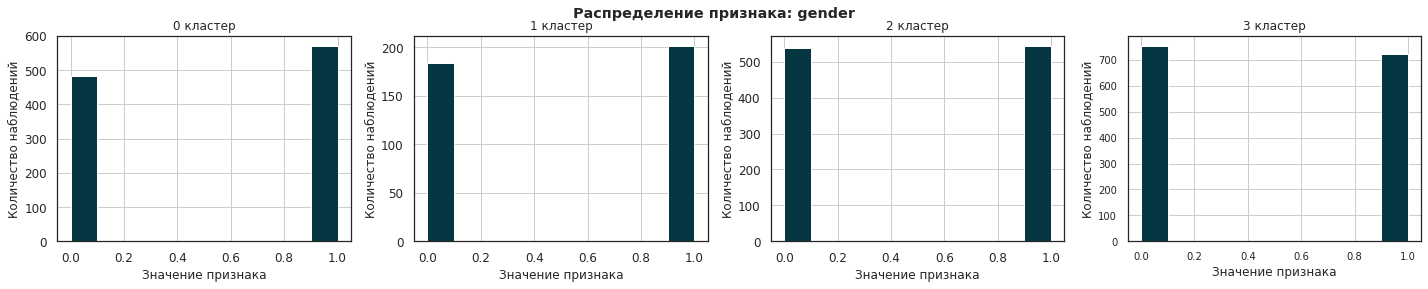

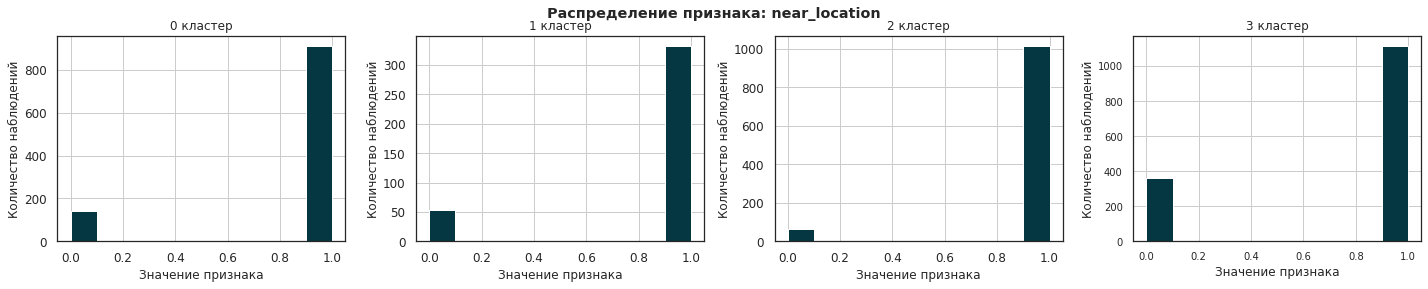

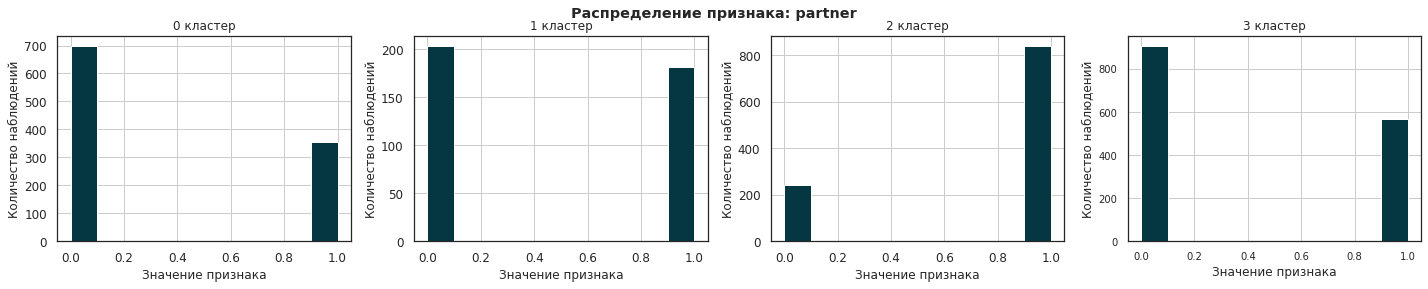

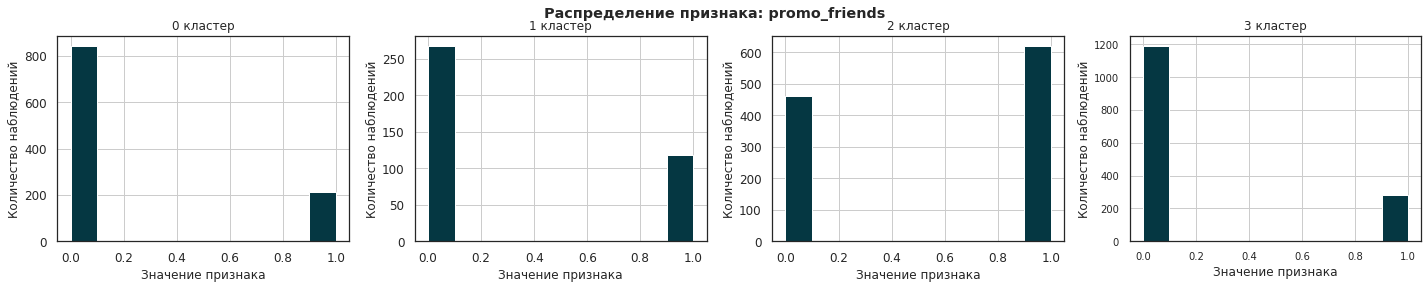

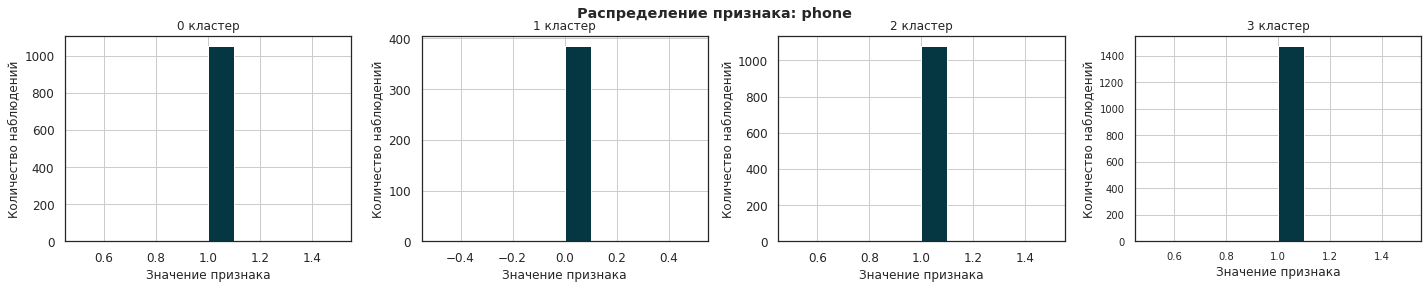

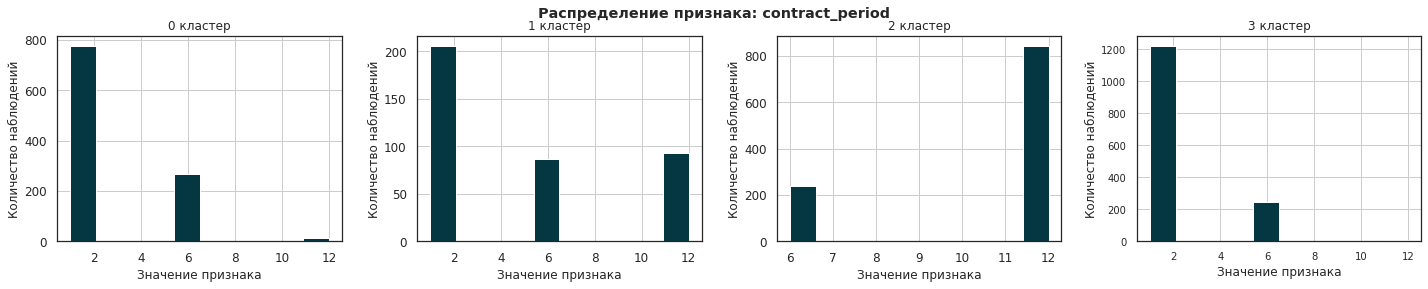

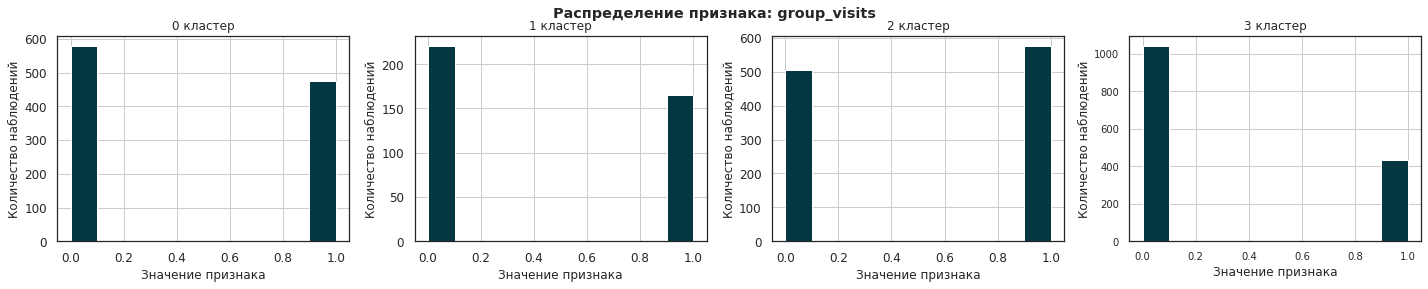

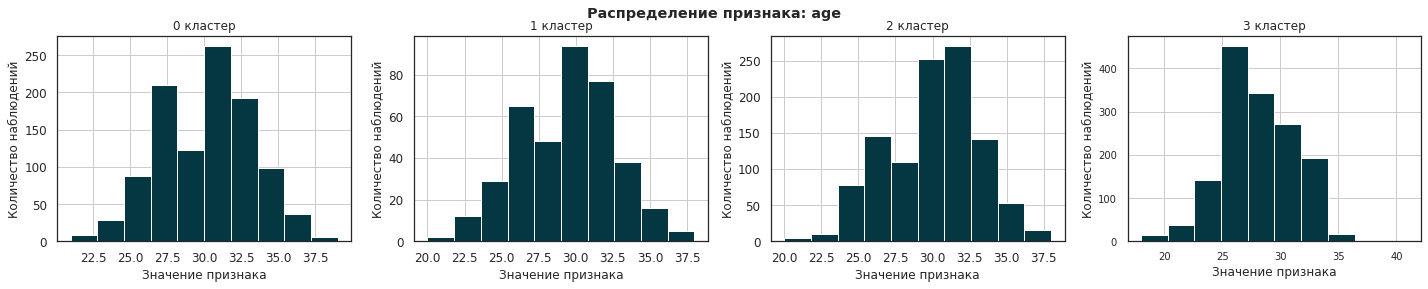

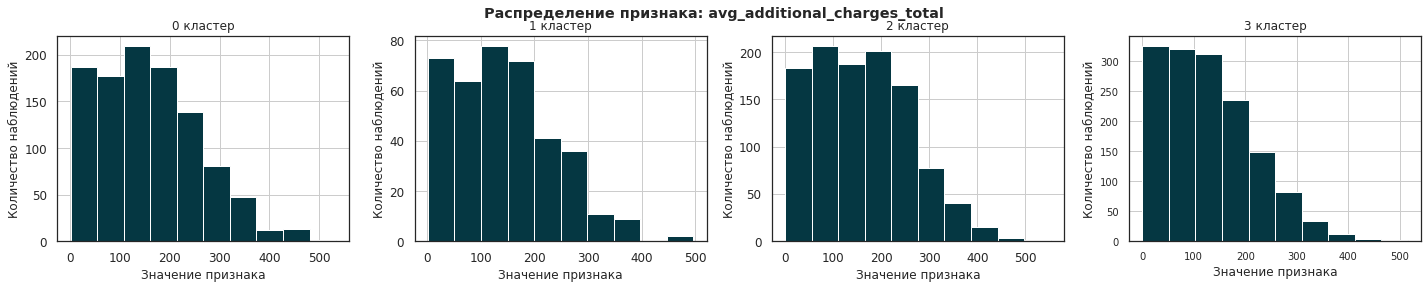

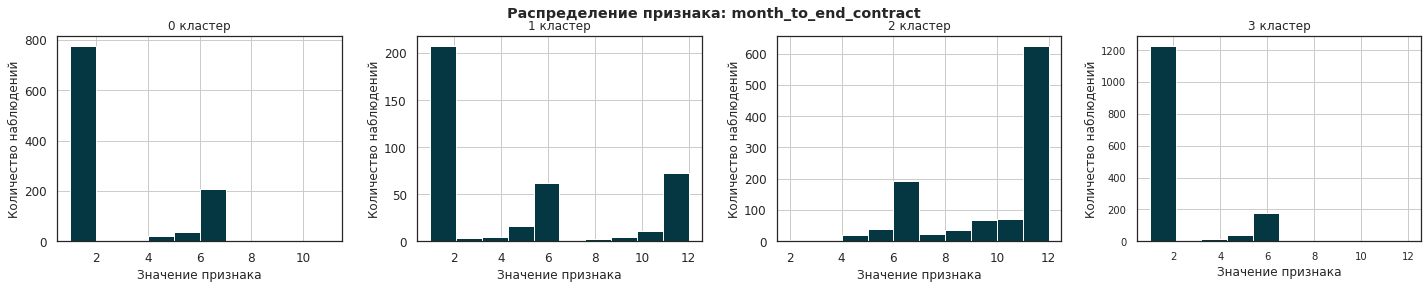

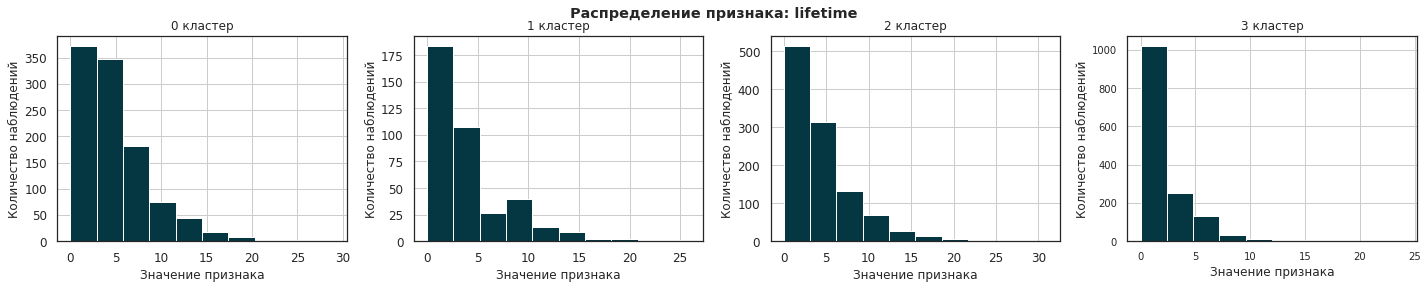

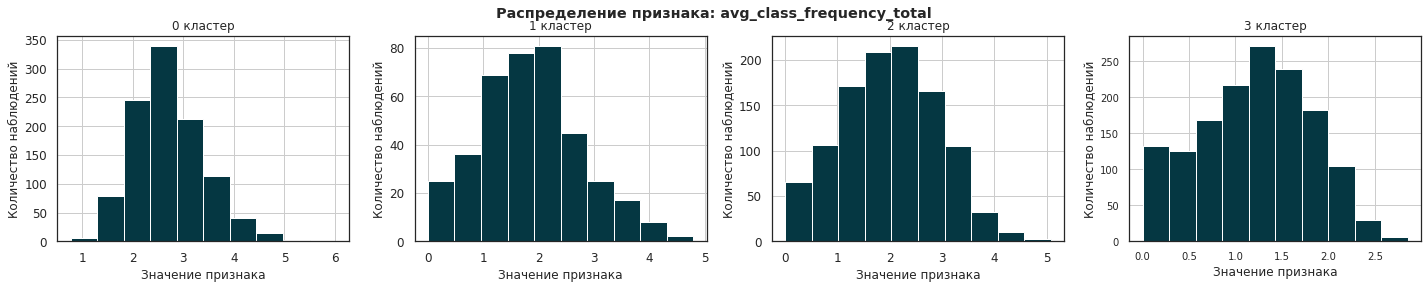

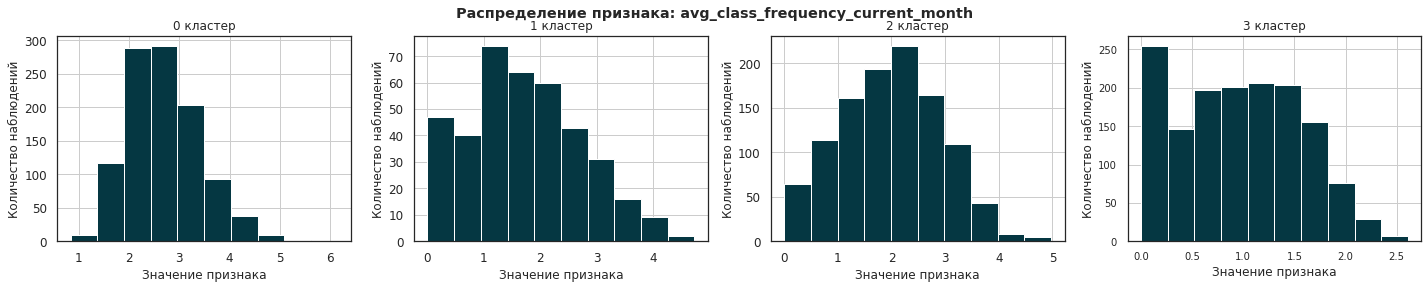

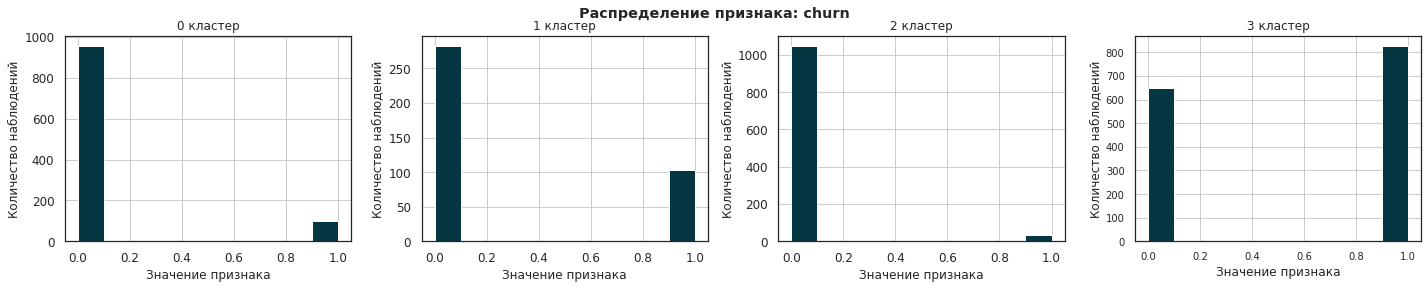

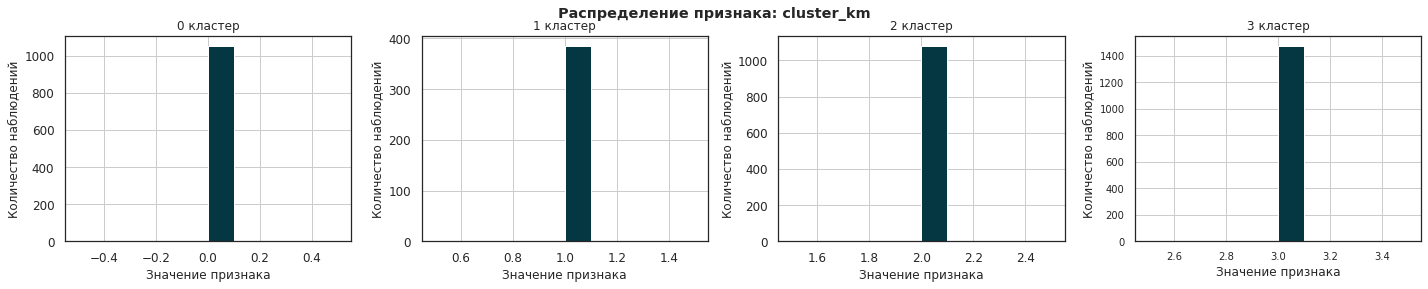

In [ ]:
for feature in df.columns:
    cluster_histogram(feature)

In [ ]:
df.groupby('cluster_km')['churn'].mean().round(2).sort_values(ascending=False)

cluster_km
3    0.56
1    0.27
0    0.09
2    0.03
Name: churn, dtype: float64

Исходя из результатов средних показателей признаков и графиков распределений, можно сделать вывод
***

**В кластере 2 самый низкий отток** благодаря тому, что большниство значений принимают признак:
- Проиживание или место работы в  одном районе с клубом;
- Клиенты являются сотрдуниками компаний-партнеров;
- Клиенты приходят по акцции "Приведи друга";
- Самый выскоий контрактный период *(годовой абонемент)*;
- Клиенты посещают групповые занятия.

**В кластере 3 самый высокий отток** из-за того, что:
- Клиенты этого кластера как правило не сотрудники компаний-партенров;
- Они живут и работают в другом раойне - количество таких клиентов здесь больше чем в других кластерах.
- Они берут самый низкий контрактный период и мало ходят на групповые занятия;
- Клиенты этого кластера тратят меньше средств доп.услуги и редко посещают клуб.


<a id='fin'></a>
## Вывод
***
1. Мы построили модель алгоритмом "Случайный лес" и спрогнозировали отток. Такая модель корректно прогнозирует отток клиентов в 82% случаев.
2. Благодаря кластеризации получилось резделить клиентов на группы: сотрудник компаний-партнеров и другие.
3. По результатом проведенного анализа были выявлены признаки, влияющие на целевуюю переменную. Ниже выводы с рекомендациями по повышению качества работы с клиентами:
    - **Клиентов клуба необходимо разделять** на сотрудников компаний-партнеров клубов и тех, которые не имеют отношение к партнерству клуба. Как правило, первая группа не покинет клуб, а вторая уйдет в ближайшее время.
    - **Рекомендуется переводить занятия на групповые или открывать новые групповые** - сотрудникам нравится общаться с коллегами вне офиса и вместе достигать результатов. Это их сплочает и отбивает желание уходить в другое место.
    - **Стоит обудмать новые виды акций** направленных на совместное посещение. Например "Пара в тенис" или "Родственный волейбол". Такие акции будут нацелены на то, что клиенты буду держаться одного места.
    - **Необходимо рассмотреть возможность сопровождения клиентов**. Клиенты, которые в течении недели редко ходят в зал со временем уйдут. С таким клиентами следует работать по части дачи обратной связи: либо обзвон, либо почтовые уведомления, анкетирование и д.р.
